# **RFM Analysis on Customer Sales Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import necessary libraries and data load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Load the dataset

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Dataset/online_retail_dataset.csv', dtype={'CustomerID':str}, parse_dates=['InvoiceDate'])
df = dataset.copy()

### Data pre-processing

Derived 'Sales' column from quantity sold and unit price of each item

In [4]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
 8   Sales        541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,Sales
count,541909.000000,541909,541909.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,17.987795
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,-168469.600000
25%,1.000000,2011-03-28 11:34:00,1.250000,3.400000
50%,3.000000,2011-07-19 17:17:00,2.080000,9.750000
75%,10.000000,2011-10-19 11:27:00,4.130000,17.400000
max,80995.000000,2011-12-09 12:50:00,38970.000000,168469.600000
std,218.081158,NaN,96.759853,378.810824


In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Exctracting necessary columns for RFM Analysis by taking:
*   **CustomerID:** The grouping column for various aggregation
*   **InvoiceDate:** Day difference between date of invoice generation and date of analysis
*   **InvoiceNo:** Number of Invoices generated for a customer
*   **Sales:** Total sales generated for a customer

In [8]:
columns_to_analyse = ['CustomerID','InvoiceDate','InvoiceNo','Sales']
df_analysis = df[columns_to_analyse]
df_analysis

,CustomerID,InvoiceDate,InvoiceNo,Sales
0,17850.0,2010-12-01 08:26:00,536365,15.30
1,17850.0,2010-12-01 08:26:00,536365,20.34
2,17850.0,2010-12-01 08:26:00,536365,22.00
3,17850.0,2010-12-01 08:26:00,536365,20.34
4,17850.0,2010-12-01 08:26:00,536365,20.34
...,...,...,...,...
541904,12680.0,2011-12-09 12:50:00,581587,10.20
541905,12680.0,2011-12-09 12:50:00,581587,12.60
541906,12680.0,2011-12-09 12:50:00,581587,16.60
541907,12680.0,2011-12-09 12:50:00,581587,16.60


Assuming 'Date of Analysis' one day after the most recent purchase by any customer

In [9]:
date_of_analysis = df_analysis['InvoiceDate'].max() + dt.timedelta(days=1)
date_of_analysis

Timestamp('2011-12-10 12:50:00')

Performing the necessary aggregations required:

In [10]:
df_rfm = df_analysis.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (date_of_analysis - x.max()).days,
    'InvoiceNo': 'count',
    'Sales': 'sum'
})

Renaming each column to corresponding RFM metrics:

In [11]:
df_rfm = df_rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Sales': 'Monetary'
})

Once calculated the recency, frequency, and monetary values for each customer, Assigning scores or rankings for each category using `qcut` method.

**RFM Scaling:**
Scale of 1 to 5, with 5 being the highest score without breaking the normalization of data:
*   Recency: 5 (recent purchase), 1 (distant purchase)
*   Frequency: 5 (frequent purchases), 1 (infrequent purchases)
*   Monetary: 5 (high spending), 1 (low spending)

In [12]:
recency_label = range(5,0,-1)
frequency_label = range(1,6)
monetary_label = range(1,6)

recency_grp = pd.qcut(df_rfm['Recency'], q=5, labels=recency_label)
frequency_grp = pd.qcut(df_rfm['Frequency'], q=5, labels=frequency_label)
monetary_grp = pd.qcut(df_rfm['Monetary'], q=5, labels=monetary_label)

df_rfm = df_rfm.assign(R=recency_grp, F=frequency_grp, M=monetary_grp)

In [13]:
df_rfm

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,5,5,5
12348.0,75,31,1797.24,2,3,4
12349.0,19,73,1757.55,4,4,4
12350.0,310,17,334.40,1,2,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,13,176.60,5,1,1


Function to convert the categorical values of RFM column into numerical value:

In [14]:
def cat_to_numeric(x):
  return pd.to_numeric(x)

In [15]:
cols_to_numeric = ['R','F','M']
df_rfm[cols_to_numeric] = df_rfm[cols_to_numeric].apply(cat_to_numeric)

Combine the scores to create customer segments:
*   Platinum Plus: Total Score 14 or above
*   Platinum: Total Score between 11 and 13
*   Gold: Total Score between 8 and 10
*   Silver: Total Score between 5 and 7
*   Bronze: Total Score 4 or below


In [16]:
df_rfm['RFMScore'] = df_rfm[['R','F','M']].sum(axis=1)

In [17]:
min_rfm = df_rfm['RFMScore'].min()
max_rfm = df_rfm['RFMScore'].max()

print(f"Minimum RFM Score: {min_rfm}")
print(f"Maximum RFM Score: {max_rfm}")

Minimum RFM Score: 3
Maximum RFM Score: 15


In [18]:
def rfm_label(df):
  if df['RFMScore'] >= 14:
    return 'Platinum Plus'
  elif (df['RFMScore'] >= 11) and (df['RFMScore'] < 14):
    return 'Platinum'
  elif (df['RFMScore'] >= 8 and df['RFMScore'] < 11):
    return 'Gold'
  elif (df['RFMScore'] >= 5) and (df['RFMScore'] < 8):
    return 'Silver'
  else:
    return 'Bronze'

From the distribution below we can observe:
*   Customer with ID **12347** is a High-Value customer with high recency, high frequency, and high spending record
*   While, Customer with ID **12346** is a customer who is more likely to Churn with distant recency, infrequent, low spending record

In [19]:
df_rfm['RFM Level'] = df_rfm.apply(rfm_label, axis=1)
df_rfm.head(30)

,Recency,Frequency,Monetary,R,F,M,RFMScore,RFM Level
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,3,Bronze
12347.0,2,182,4310.00,5,5,5,15,Platinum Plus
12348.0,75,31,1797.24,2,3,4,9,Gold
12349.0,19,73,1757.55,4,4,4,12,Platinum
12350.0,310,17,334.40,1,2,2,5,Silver
12352.0,36,95,1545.41,3,4,4,11,Platinum
12353.0,204,4,89.00,1,1,1,3,Bronze
12354.0,232,58,1079.40,1,3,4,8,Gold
12355.0,214,13,459.40,1,1,2,4,Bronze


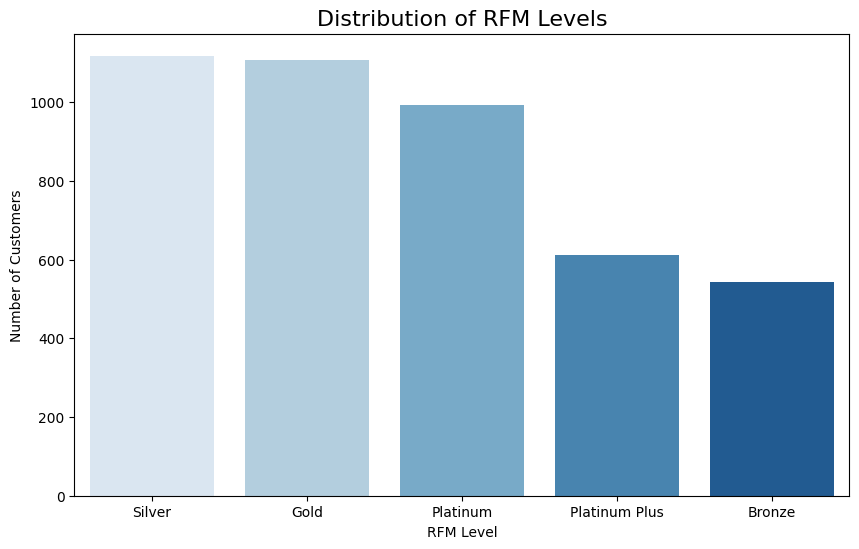

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(
    x='RFM Level',
    data=df_rfm,
    order=df_rfm['RFM Level'].value_counts(ascending=False).index,
    palette='Blues'
)


plt.title('Distribution of RFM Levels', fontsize=16)
plt.xlabel('RFM Level')
plt.ylabel('Number of Customers')

plt.show()